In [1]:
import numpy as np

import pandas as pd

from tqdm import tqdm

import seaborn as sns

from joblib import dump#, load

import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler#, StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential#, load_model
from keras.layers import Input, LSTM, RepeatVector, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

Definindo o tema do seaborn:

In [2]:
sns.set_theme()

Definição da SEED:

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED) # Numpy

# Carregando os dados

Os valores são números muito pequenos com muitas casas decimais, por isso é bom que o dataframe consiga representar isso também.

In [4]:
pd.set_option('display.float_format', '{:.20f}'.format)

Carregando os dados:

In [5]:
df_benign = pd.read_csv("data/dados benignos/mensagens_benignas.csv")
df_benign_2 = pd.read_csv("data/dados benignos/mensagens_benignas_2.csv")
df_benign = pd.concat([df_benign, df_benign_2], axis=0)

del df_benign_2

In [6]:
df_malicious_random_dos = pd.read_csv("data/ataques/mensagens_maliciosas_random_dos.csv")
df_malicious_spoofing_zero_payload = pd.read_csv("data/ataques/mensagens_maliciosas_spoofing_zero_payload.csv")
df_malicious_zero_dos = pd.read_csv("data/ataques/mensagens_maliciosas_zero_dos.csv")

In [7]:
df_benign

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,3,193,0,0,0,-1
1,0.00012946128845210000,3,193,0,0,0,-1
2,0.00015544891357419999,3,193,0,0,0,-1
3,0.00015616416931149999,3,193,0,0,0,-1
4,0.00013208389282220000,2,194,24,0,-1,-1
...,...,...,...,...,...,...,...
943319,0.00013184547424310001,2,194,253,255,-1,-1
943320,0.00016784667968750000,4,192,160,134,1,100
943321,0.00016760826110829999,4,192,160,134,1,100
943322,0.00016283988952629999,4,192,160,134,1,100


In [8]:
df_malicious_random_dos

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,192,17,110,1,93
1,0.00037145614624020001,1,1061,225,-1,-1,-1
2,0.00169730186462400002,2,1412,198,237,-1,-1
3,0.00179910659790029999,1,2035,254,-1,-1,-1
4,0.00183224678039550001,3,544,66,102,79,-1
...,...,...,...,...,...,...,...
455997,0.00016474723815910000,4,192,207,106,1,92
455998,0.00016379356384270001,4,192,207,106,1,92
455999,0.00016403198242180000,4,192,207,106,1,92
456000,0.00016498565673819999,4,192,207,106,1,92


In [9]:
df_malicious_spoofing_zero_payload

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,0,0,0,0,0
1,0.00161838531494139996,4,0,0,0,0,0
2,0.00169730186462400002,4,0,0,0,0,0
3,0.00061082839965819998,4,192,0,0,0,0
4,0.00175023078918450006,4,0,0,0,0,0
...,...,...,...,...,...,...,...
568457,0.00015544891357419999,3,193,0,0,0,-1
568458,0.00015711784362790001,3,193,0,0,0,-1
568459,0.00015830993652339999,3,193,0,0,0,-1
568460,0.00012922286987300001,2,194,0,0,-1,-1


In [10]:
df_malicious_zero_dos

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,4,0,0,0,0,0
1,0.00115513801574700006,4,0,0,0,0,0
2,0.00147318840026850004,4,0,0,0,0,0
3,0.00123977661132810006,4,0,0,0,0,0
4,0.00169897079467769990,4,0,0,0,0,0
...,...,...,...,...,...,...,...
741977,0.00014257431030270001,2,194,236,255,-1,-1
741978,0.00012278556823730000,2,194,236,255,-1,-1
741979,0.00013160705566400000,2,194,236,255,-1,-1
741980,0.00016975402832030000,4,192,147,117,1,95


Manipualação da quantidade/proporção dos dados:

In [11]:
# OPCIONAL!!!
len_min = min(len(df_benign),len(df_malicious_random_dos),len(df_malicious_spoofing_zero_payload),len(df_malicious_zero_dos))
NUM_OF_ATTACKS = 3

#len_min = int(len_min / 40)

#df_benign = df_benign.head(len_min * NUM_OF_ATTACKS)
df_malicious_random_dos = df_malicious_random_dos.head(len_min)
df_malicious_spoofing_zero_payload = df_malicious_spoofing_zero_payload.head(len_min)
df_malicious_zero_dos = df_malicious_zero_dos.head(len_min)

In [12]:
del len_min

# Tratando dados

## Normalização dos dados

Criação e uso do scaler:

In [13]:
scaler = MinMaxScaler()

scaler.fit(df_benign)

df_benign_scaled = pd.DataFrame(scaler.transform(df_benign), columns=df_benign.columns, index=df_benign.index)
df_malicious_random_dos_scaled = pd.DataFrame(scaler.transform(df_malicious_random_dos), columns=df_malicious_random_dos.columns, index=df_malicious_random_dos.index)
df_malicious_spoofing_zero_payload_scaled = pd.DataFrame(scaler.transform(df_malicious_spoofing_zero_payload), columns=df_malicious_spoofing_zero_payload.columns, index=df_malicious_spoofing_zero_payload.index)
df_malicious_zero_dos_scaled = pd.DataFrame(scaler.transform(df_malicious_zero_dos), columns=df_malicious_zero_dos.columns, index=df_malicious_zero_dos.index)

In [14]:
del df_benign
del df_malicious_random_dos
del df_malicious_spoofing_zero_payload
del df_malicious_zero_dos

In [15]:
df_benign_scaled

,Timestamp,DLC,Arb ID,Byte 0,Byte 1,Byte 2,Byte 3
0,0.00000000000000000000,0.28571428571428569843,0.99473684210526325256,0.00000000000000000000,0.00390625000000000000,0.00390625000000000000,0.00000000000000000000
1,0.00016294733620110546,0.28571428571428569843,0.99473684210526325256,0.00000000000000000000,0.00390625000000000000,0.00390625000000000000,0.00000000000000000000
2,0.00019565683831150588,0.28571428571428569843,0.99473684210526325256,0.00000000000000000000,0.00390625000000000000,0.00390625000000000000,0.00000000000000000000
3,0.00019655709983747329,0.28571428571428569843,0.99473684210526325256,0.00000000000000000000,0.00390625000000000000,0.00390625000000000000,0.00000000000000000000
4,0.00016624829512965259,0.14285714285714284921,1.00000000000000000000,0.09411764705882352811,0.00390625000000000000,0.00000000000000000000,0.00000000000000000000
...,...,...,...,...,...,...,...
943319,0.00016594820795433012,0.14285714285714284921,1.00000000000000000000,0.99215686274509806708,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000
943320,0.00021126137142839994,0.42857142857142854764,0.98947368421052639409,0.62745098039215685404,0.52734375000000000000,0.00781250000000000000,1.00000000000000000000
943321,0.00021096128425295160,0.42857142857142854764,0.98947368421052639409,0.62745098039215685404,0.52734375000000000000,0.00781250000000000000,1.00000000000000000000
943322,0.00020495954074650229,0.42857142857142854764,0.98947368421052639409,0.62745098039215685404,0.52734375000000000000,0.00781250000000000000,1.00000000000000000000


## Criação de Labels

In [16]:
list_labels_benign = [1] * len(df_benign_scaled)
list_labels_random_dos = [-1] * len(df_malicious_random_dos_scaled)
list_labels_spoofing_zero_payload = [-1] * len(df_malicious_spoofing_zero_payload_scaled)
list_labels_zero_dos = [-1] * len(df_malicious_zero_dos_scaled)

classifier_type = "bc"

## Criação de Janelas Temporais

### Criação de Janelas Deslizantes

Criação da função de divisão dos dados em janelas:

In [17]:
def create_slicing_windows(data, labels, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(labels[i + time_step])
    return np.array(X), np.array(Y)

Definição do tamanho da janela:

In [18]:
WINDOW_SIZE = 150

Criação das janelas deslizantes:

In [19]:
benign_windows, benign_labels = create_slicing_windows(df_benign_scaled, list_labels_benign, WINDOW_SIZE)
del df_benign_scaled, list_labels_benign

malicious_random_dos_windows, malicious_random_dos_labels = create_slicing_windows(df_malicious_random_dos_scaled, list_labels_random_dos, WINDOW_SIZE)
del df_malicious_random_dos_scaled, list_labels_random_dos

malicious_spoofing_zero_payload_windows, malicious_spoofing_zero_payload_labels = create_slicing_windows(df_malicious_spoofing_zero_payload_scaled, list_labels_spoofing_zero_payload, WINDOW_SIZE)
del df_malicious_spoofing_zero_payload_scaled, list_labels_spoofing_zero_payload

malicious_zero_dos_windows, malicious_zero_dos_labels = create_slicing_windows(df_malicious_zero_dos_scaled, list_labels_zero_dos, WINDOW_SIZE)
del df_malicious_zero_dos_scaled, list_labels_zero_dos

In [20]:
len(benign_windows), len(benign_windows[0])

(3616991, 150)

In [21]:
benign_windows

array([[[0.00000000e+00, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [1.62947336e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [1.95656838e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        ...,
        [1.93856315e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [1.95956925e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [1.67748731e-04, 1.42857143e-01, 1.00000000e+00, ...,
         3.90625000e-03, 0.00000000e+00, 0.00000000e+00]],

       [[1.62947336e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [1.95656838e-04, 2.85714286e-01, 9.94736842e-01, ...,
         3.90625000e-03, 3.90625000e-03, 0.00000000e+00],
        [1.96557100e-04, 

## Dividindo dados em Treino, Validação e Teste

Quantidade de dados benignos dividido pelo total:

In [ ]:
len(benign_windows) / (len(benign_windows) + len(malicious_random_dos_windows) + len(malicious_spoofing_zero_payload_windows) + len(malicious_zero_dos_windows))

Concatenação das janelas, em ordem:

In [ ]:
data = np.vstack((benign_windows, malicious_random_dos_windows, malicious_spoofing_zero_payload_windows, malicious_zero_dos_windows))

In [22]:
data_malicious = np.vstack((malicious_random_dos_windows, malicious_spoofing_zero_payload_windows, malicious_zero_dos_windows))

In [ ]:
data_labels = np.hstack((benign_labels, malicious_random_dos_labels, malicious_spoofing_zero_payload_labels, malicious_zero_dos_labels))

In [23]:
data_malicious_labels = np.hstack((malicious_random_dos_labels, malicious_spoofing_zero_payload_labels, malicious_zero_dos_labels))

In [24]:
del malicious_random_dos_windows
del malicious_spoofing_zero_payload_windows
del malicious_zero_dos_windows
del malicious_random_dos_labels
del malicious_spoofing_zero_payload_labels
del malicious_zero_dos_labels
del benign_labels

### Divisão em treino, validação e teste.

#### Abordagem supervisionada:

In [ ]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data, data_labels, test_size=0.25, random_state=RANDOM_SEED)

In [ ]:
val_data, test_data, val_labels, test_labels = train_test_split(val_test_data, val_test_labels, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
del data, data_labels
del val_test_data, val_test_labels

#### Abordagem não-supervisionada:

In [ ]:
train_data_2 = benign_windows[:int((len(benign_windows) // 1.05))]

In [26]:
test_data_2 = np.vstack((data_malicious, benign_windows[int((len(benign_windows) // 1.05)):]))

In [ ]:
malicious_proportion = len(data_malicious) / (len(data_malicious) + len(benign_windows[int((len(benign_windows) // 1.05)):]))
malicious_proportion

In [55]:
benign_labels = [1] * int(len(benign_windows) - (len(benign_windows) // 1.05))

test_data_2_labels = np.hstack((data_malicious_labels, benign_labels))

In [57]:
del data_malicious
del benign_windows
del benign_labels
del data_malicious_labels

### Shape dos dados de treino:

In [ ]:
train_data.shape

In [ ]:
train_data_2.shape

# IAs

## LSTM (supervisionado)

Variável que define se é supervisionado ou não-supervisionado:

In [ ]:
s_OR_ns = "s"

Quantidade de features, para o modelo lidar com as entradas:

In [ ]:
FEATURES_COUNT = train_data.shape[2] # Número de features dos dados

Construção do modelo LSTM:

In [ ]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(WINDOW_SIZE, FEATURES_COUNT)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, kernel_regularizer=l2(0.0000001)))

# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse')
#model.compile(optimizer="adam", loss='mse')

Definição da paciência:

In [ ]:
PATIENCE = 4

Configuração do early stop:

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

Definição da quantidade de épocas e da quantidade de batchs:

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32 #padrão: batch_size=32

**TREINAMENTO DO MODELO:**

In [ ]:
# Treinando o modelo
history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels), callbacks=[early_stopping])

In [ ]:
del train_data, train_labels
del val_data, val_labels

In [ ]:
# Avaliando o modelo no conjunto de teste
loss = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)

In [ ]:
predicts = model.predict(test_data)
predicts

Transformando as predições em uma numpy array unidimensional:

In [ ]:
predicts_1d = np.array([predict[0] for predict in predicts])
predicts_1d

In [ ]:
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

In [ ]:
plot_precision_recall_curve(test_labels, predicts_1d)

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
plot_roc_curve(test_labels, predicts_1d)

Transformando todos os valores de predições acima de 0 em 1, enquanto os outros recebem a função round(), ou seja, serão arredondados pro número inteiro mais próximo. Após isso, os números que forem iguais a 0, serão transformados em -1. É como se todo mundo igual ou menor que 0, fosse malicioso, mas 0 não é um valor malicioso de label, é mais como se fosse um threshold, então nada deve ser igual a 0. Esse problema é minimizado em classificações binárias.

In [ ]:
predicts_1d = np.where(predicts_1d > 0, 1, np.round(predicts_1d))
predicts_1d = np.where(predicts_1d == 0, -1, predicts_1d)
predicts_1d

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

In [ ]:
plot_confusion_matrix(test_labels, predicts_1d)

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
get_overall_metrics(test_labels, predicts_1d)

In [ ]:
del test_data, test_labels

Salvando modelo com diferentes bibliotecas:

In [ ]:
model.save(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}.keras')

In [ ]:
with open(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)

In [ ]:
dump(model, f"models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}.joblib")

In [ ]:
dump(scaler, f"models/scalers/scaler_model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}")

In [ ]:
del history
del loss
del predicts
del predicts_1d

## LSTM (não-supervisionado)

In [58]:
s_OR_ns = "ns"
classifier_type = "bc"

In [ ]:
FEATURES_COUNT = train_data_2.shape[2]

In [ ]:
# Construindo o modelo Autoencoder LSTM
inputs = Input(shape=(WINDOW_SIZE, FEATURES_COUNT))
encoded = LSTM(50, activation='tanh', return_sequences=False)(inputs)  # Codificador
decoded = RepeatVector(WINDOW_SIZE)(encoded)  # Decodificador
decoded = LSTM(FEATURES_COUNT, return_sequences=True)(decoded)

# Adicionando Dropout e Normalização em Batch
decoded = Dropout(0.1)(decoded)
decoded = BatchNormalization()(decoded)

# Camada de saída
outputs = Dense(FEATURES_COUNT, kernel_regularizer=l2(0.0000001))(decoded)

# Compilando o modelo
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.004), loss='mse')

In [ ]:
PATIENCE = 4

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32#padrão: batch_size=32

**TREINAMENTO DO MODELO:**

In [ ]:
history = model.fit(train_data_2, train_data_2, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
del train_data_2

In [59]:
from keras.models import load_model

model = load_model("models\model_LSTM_ns_bc_ws150_tX.keras")

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\henri\AppData\Local\Temp\ipykernel_41600\2791679937.py:3: SyntaxWarning: invalid escape sequence '\m'
  model = load_model("models\model_LSTM_ns_bc_ws150_tX.keras")


In [60]:
predicts = model.predict(test_data_2)
predicts

48119/48119 ━━━━━━━━━━━━━━━━━━━━ 495s 10ms/step


array([[[5.90628304e-04, 1.50434390e-01, 9.27782714e-01, ...,
         1.31968826e-01, 5.61843887e-02, 1.55984402e-01],
        [5.13666368e-04, 1.45465046e-01, 9.23169434e-01, ...,
         1.33518860e-01, 6.32943213e-02, 1.50651649e-01],
        [5.84012771e-04, 1.53445005e-01, 9.28535998e-01, ...,
         1.17618948e-01, 3.47976759e-02, 1.62395433e-01],
        ...,
        [5.16742235e-04, 1.45863742e-01, 9.23590422e-01, ...,
         1.34396687e-01, 6.47550672e-02, 1.50414571e-01],
        [5.97250531e-04, 1.55171916e-01, 9.29720759e-01, ...,
         1.20352745e-01, 3.66742089e-02, 1.64031416e-01],
        [5.16742235e-04, 1.45863742e-01, 9.23590422e-01, ...,
         1.34396687e-01, 6.47550672e-02, 1.50414571e-01]],

       [[6.03202323e-04, 1.51705578e-01, 9.28880751e-01, ...,
         1.33786842e-01, 5.86598702e-02, 1.56007975e-01],
        [5.14083367e-04, 1.45655766e-01, 9.23188508e-01, ...,
         1.32683381e-01, 6.18058443e-02, 1.51207820e-01],
        [5.87164366e-04, 

In [61]:
def mean_square_error(original_data, predicted_data, threshold=0.5):
    """
    Função para classificar as amostras como benignas (1) ou malignas (-1) com base no erro de reconstrução.

    Parâmetros:
        original_data (numpy.array): Os dados originais.
        predicted_data (numpy.array): As previsões geradas pelo modelo autoencoder.
        threshold (float): O limiar de decisão para classificar as amostras.

    Retorna:
        numpy.array: Um array de classificação binária para cada amostra.
    """
    # Calcula o erro de reconstrução (MSE) para cada amostra
    reconstruction_errors = np.mean(np.square(original_data - predicted_data), axis=(1, 2))

    # Classifica as amostras com base no limiar
    classifications = np.where(reconstruction_errors < threshold, 1, -1)

    #del reconstruction_errors

    return classifications, reconstruction_errors

In [62]:
def mean_absolute_error(original_data, reconstructed_data, threshold=0.5):
    
    """
    Calcula o Erro Absoluto Médio (MAE) entre os dados originais e reconstruídos.

    Args:
    - original_data: array NumPy contendo os dados originais.
    - reconstructed_data: array NumPy contendo os dados reconstruídos pelo modelo.

    Returns:
    - mae: o Erro Absoluto Médio entre os dados originais e reconstruídos.
    """


    # Calcula a diferença absoluta entre os dados originais e reconstruídos
    # Calcula o MAE como a média da diferença absoluta
    mae = np.mean((np.abs(original_data - reconstructed_data)), axis=(1, 2))

    classifications = np.where(mae < threshold, 1, -1)

    del mae

    return classifications

In [63]:
def find_best_threshold_mse(original_data, predicted_data, proportion, threshold=0.5):

    reconstruction_errors = np.mean(np.square(original_data - predicted_data), axis=(1, 2))

    classifications = np.where(reconstruction_errors < threshold, 1, -1)

    del reconstruction_errors

    proportion_predicted = len(classifications[classifications == -1]) / len(classifications)

    del classifications

    print(f"Threshold: {threshold}, Proportion_predicted: {proportion_predicted}")

    if proportion_predicted < proportion:
        del proportion_predicted
        return find_best_threshold_mse(original_data, predicted_data, proportion, 0.9*threshold)
    elif proportion_predicted > proportion:
        del proportion_predicted
        return find_best_threshold_mse(original_data, predicted_data, proportion, 1.1*threshold)
    else:
        del proportion_predicted
        return threshold

In [64]:
def find_best_threshold(y_true, y_scores):
    """
    Encontra o melhor threshold baseado na proporção correta entre dados malignos e benignos.

    Parameters:
    y_true (np.array): Array de valores verdadeiros (-1 para benigno, 1 para maligno)
    y_scores (np.array): Array de scores preditos pelo modelo

    Returns:
    float: Melhor threshold encontrado
    """
    
    # Certificar que os inputs são arrays numpy
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Ordenar os scores e calcular possíveis thresholds
    thresholds = np.sort(y_scores)
    
    # Inicializar variáveis para acompanhar o melhor threshold e melhor acurácia ponderada
    best_threshold = None
    best_weighted_accuracy = -np.inf
    
    # Calcular proporção dos dados malignos e benignos
    prop_malignos = np.sum(y_true == 1) / len(y_true)
    prop_benignos = np.sum(y_true == -1) / len(y_true)
    
    for threshold in tqdm(thresholds):
        # Calcular predições baseadas no threshold atual
        y_pred = np.where(y_scores >= threshold, 1, -1)
        
        # Calcular acurácia ponderada
        accuracy_malignos = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)
        accuracy_benignos = np.sum((y_true == -1) & (y_pred == -1)) / np.sum(y_true == -1)
        
        weighted_accuracy = prop_malignos * accuracy_malignos + prop_benignos * accuracy_benignos
        
        # Atualizar melhor threshold se a acurácia ponderada atual for melhor
        if weighted_accuracy > best_weighted_accuracy:
            best_weighted_accuracy = weighted_accuracy
            best_threshold = threshold
    
    return best_threshold

In [65]:
classifications_mse, reconstruction_errors = mean_square_error(test_data_2, predicts)

In [66]:
#THRESHOLD = find_best_threshold_mse(test_data_2, predicts, malicious_proportion, 0.04415)
THRESHOLD = find_best_threshold(test_data_2_labels, reconstruction_errors)

100%|██████████| 1539794/1539794 [2:56:42<00:00, 145.23it/s]  


6451

In [83]:
reconstruction_errors

array([1.21189877, 1.21080016, 1.19135854, ..., 0.11128967, 0.11210935,
       0.11195218])

In [82]:
print(THRESHOLD)

6541.580257623417


In [67]:
classifications_mse, reconstruction_errors = mean_square_error(test_data_2, predicts, THRESHOLD)

In [68]:
len(classifications_mse[classifications_mse == -1]) / len(classifications_mse), malicious_proportion

NameError: name 'malicious_proportion' is not defined

In [73]:
reconstruction_errors_rounded = np.where(reconstruction_errors > THRESHOLD, -1, 1)
reconstruction_errors_rounded

array([1, 1, 1, ..., 1, 1, 1])

In [74]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

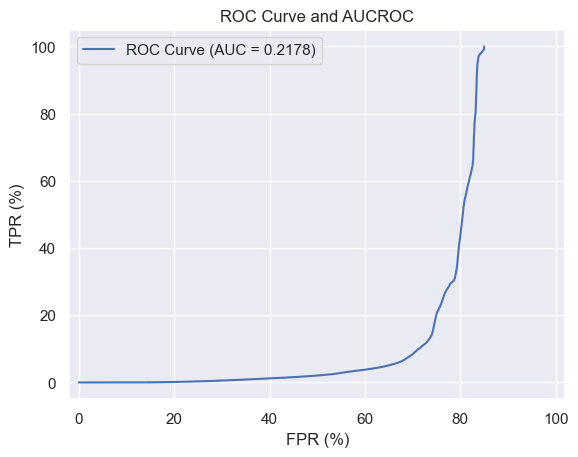

In [75]:
plot_roc_curve(test_data_2_labels, 1/reconstruction_errors)

In [76]:
def plot_precision_recall_curve(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

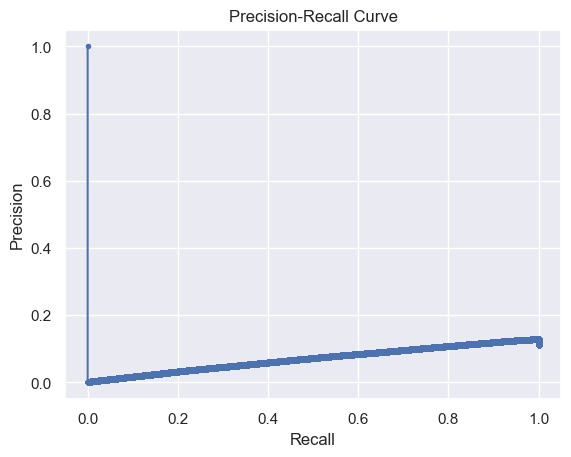

In [77]:
plot_precision_recall_curve(test_data_2_labels, 1/reconstruction_errors)

In [78]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

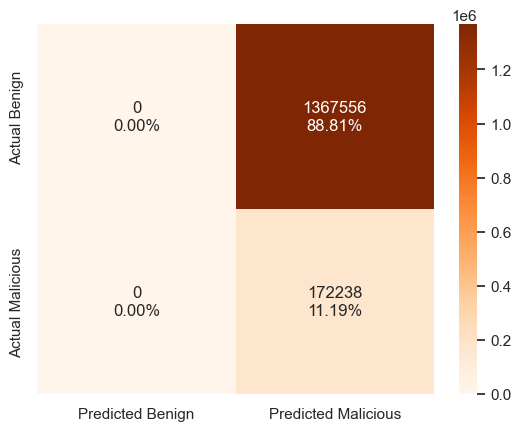

In [79]:
plot_confusion_matrix(test_data_2_labels, reconstruction_errors_rounded)

In [80]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [81]:
get_overall_metrics(test_data_2_labels, reconstruction_errors_rounded)

{'acc': 0.1118578199421481,
 'tpr': 1.0,
 'fpr': 1.0,
 'precision': 0.1118578199421481,
 'f1-score': 0.20120885590923535}

Salvando modelo com diferentes bibliotecas:

In [ ]:
THRESHOLD = str(THRESHOLD).replace(".",",")

In [ ]:
model.save(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}.keras')

In [ ]:
with open(f'models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}.pkl', 'wb') as arquivo:
    pickle.dump(model, arquivo)

In [ ]:
dump(model, f"models/model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}.joblib")

In [ ]:
dump(scaler, f"models/scalers/scaler_model_LSTM_{s_OR_ns}_{classifier_type}_ws{WINDOW_SIZE}_t{THRESHOLD}")

# Extras

In [ ]:
import sys
import pandas as pd

# Função para obter o tamanho das variáveis
def get_memory_usage():
    var_memory = [(var, sys.getsizeof(globals()[var])) for var in globals() if not var.startswith("_") and not callable(globals()[var])]
    return pd.DataFrame(var_memory, columns=['Variable', 'Memory_Bytes']).sort_values(by='Memory_Bytes', ascending=False)

# Obter e mostrar o uso de memória
memory_usage_df = get_memory_usage()
print(memory_usage_df)